In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/cifar10/sisa

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 421 (delta 4), reused 8 (delta 3), pack-reused 374 (from 3)
Receiving objects: 100% (421/421), 628.69 MiB | 42.88 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (74/74), done.
/kaggle/working/machine_unlearning_experiments/experiments/cifar10/sisa


## Dependencies

In [2]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [10]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Init model
from models.resnet50 import init_model_resnet50

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
import methods.sisa.sisa_train_test as stt
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cuda


## Parameters (arbitrary chosen)

In [26]:
BATCH_SIZE = 256

LEARNING_RATE = 5e-5

EPOCHS = 5

SHARDS = 3

SLICES = 5

stt.MULTI_GPU = True

# SISA structure

## Get data transform

In [27]:
*_, transform = init_model_resnet50()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...
Done initializing model.
Model ID: 137298102213632, Optimizer ID: 137298023217760, Criterion ID: 137298023217712


## Load dataset

In [28]:
train_dataset = datasets.CIFAR10(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_root, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Create SISA structure

In [8]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES)

SISA structure saved to sisa_structure.json


In [9]:
sisa_structure_file = 'sisa_structure.json'

## Prepare DataLoaders from json file

In [10]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

# Train using SISA framework

## Models output path

In [11]:
save_models_metrics_dir = './sisa_models'

## Call train

In [12]:
import time

start_time = time.perf_counter()
sisa_train(
    dataloaders=dataloaders, 
    num_epochs=EPOCHS, 
    save_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_resnet50,
    learning_rate=LEARNING_RATE,
    )

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Training shard: shard_0
Init model...
Done initializing model.
Model ID: 133947227881776, Optimizer ID: 133947221933840, Criterion ID: 133947221933984
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch [1/5], Train Loss: 2.1566, Train Accuracy: 0.3350, Val Loss: 2.0697, Val Accuracy: 0.5105
Epoch 1: New best validation accuracy: 0.5105. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch [2/5], Train Loss: 1.6209, Train Accuracy: 0.6977, Val Loss: 1.2202, Val Accuracy: 0.7357
Epoch 2: New best validation accuracy: 0.7357. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch [3/5], Train Loss: 0.9473, Train Accuracy: 0.8127, Val Loss: 0.6389, Val Accuracy: 0.8138
Epoch 3: New best validation accuracy: 0.8138. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch [4/5], Train Loss: 0.4572, Train Accuracy: 0.9023, Val Loss: 0.4402, Val Accuracy: 0.8529
Epoch 4: New best validation accuracy: 0.8529. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch [5/5], Train Loss: 0.2117, Train Accuracy: 0.9583, Val Loss: 0.3875, Val Accuracy: 0.8829
Epoch 5: New best validation accuracy: 0.8829. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch [1/5], Train Loss: 0.4663, Train Accuracy: 0.8553, Val Loss: 0.3567, Val Accuracy: 0.8949
Epoch 1: New best validation accuracy: 0.8949. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch [2/5], Train Loss: 0.1829, Train Accuracy: 0.9603, Val Loss: 0.2990, Val Accuracy: 0.8979
Epoch 2: New best validation accuracy: 0.8979. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch [3/5], Train Loss: 0.0879, Train Accuracy: 0.9830, Val Loss: 0.2876, Val Accuracy: 0.9129
Epoch 3: New best validation accuracy: 0.9129. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [4/5], Train Loss: 0.0468, Train Accuracy: 0.9947, Val Loss: 0.2840, Val Accuracy: 0.9129


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [5/5], Train Loss: 0.0286, Train Accuracy: 0.9977, Val Loss: 0.3059, Val Accuracy: 0.9159
Epoch 5: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch [1/5], Train Loss: 0.3528, Train Accuracy: 0.8907, Val Loss: 0.3431, Val Accuracy: 0.8559
Epoch 1: New best validation accuracy: 0.8559. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch [2/5], Train Loss: 0.1171, Train Accuracy: 0.9700, Val Loss: 0.2602, Val Accuracy: 0.9009
Epoch 2: New best validation accuracy: 0.9009. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch [3/5], Train Loss: 0.0477, Train Accuracy: 0.9923, Val Loss: 0.2579, Val Accuracy: 0.9039
Epoch 3: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [4/5], Train Loss: 0.0250, Train Accuracy: 0.9973, Val Loss: 0.2901, Val Accuracy: 0.8919


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [5/5], Train Loss: 0.0209, Train Accuracy: 0.9970, Val Loss: 0.2766, Val Accuracy: 0.9099
Epoch 5: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch [1/5], Train Loss: 0.3350, Train Accuracy: 0.8997, Val Loss: 0.3187, Val Accuracy: 0.9069
Epoch 1: New best validation accuracy: 0.9069. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch [2/5], Train Loss: 0.1205, Train Accuracy: 0.9693, Val Loss: 0.2563, Val Accuracy: 0.9159
Epoch 2: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch [3/5], Train Loss: 0.0467, Train Accuracy: 0.9897, Val Loss: 0.2378, Val Accuracy: 0.9159


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch [4/5], Train Loss: 0.0311, Train Accuracy: 0.9943, Val Loss: 0.2179, Val Accuracy: 0.9309
Epoch 4: New best validation accuracy: 0.9309. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch [5/5], Train Loss: 0.0182, Train Accuracy: 0.9977, Val Loss: 0.2152, Val Accuracy: 0.9279
Training complete for ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch [1/5], Train Loss: 0.2999, Train Accuracy: 0.9080, Val Loss: 0.2608, Val Accuracy: 0.9069
Epoch 1: New best validation accuracy: 0.9069. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch [2/5], Train Loss: 0.0924, Train Accuracy: 0.9740, Val Loss: 0.2514, Val Accuracy: 0.9249
Epoch 2: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch [3/5], Train Loss: 0.0376, Train Accuracy: 0.9917, Val Loss: 0.2729, Val Accuracy: 0.9219


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch [4/5], Train Loss: 0.0197, Train Accuracy: 0.9987, Val Loss: 0.2627, Val Accuracy: 0.9279
Epoch 4: New best validation accuracy: 0.9279. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [5/5], Train Loss: 0.0147, Train Accuracy: 0.9987, Val Loss: 0.2754, Val Accuracy: 0.9219
Training complete for ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_0_final_model.pth
Training shard: shard_1
Init model...
Done initializing model.
Model ID: 133947227797248, Optimizer ID: 133947138914240, Criterion ID: 133947138903872
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch [1/5], Train Loss: 2.1929, Train Accuracy: 0.2827, Val Loss: 2.1209, Val Accuracy: 0.4264
Epoch 1: New best validation accuracy: 0.4264. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [2/5], Train Loss: 1.7108, Train Accuracy: 0.6850, Val Loss: 1.4040, Val Accuracy: 0.6156
Epoch 2: New best validation accuracy: 0.6156. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch [3/5], Train Loss: 1.0321, Train Accuracy: 0.7973, Val Loss: 0.6895, Val Accuracy: 0.8018
Epoch 3: New best validation accuracy: 0.8018. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.5169, Train Accuracy: 0.8840, Val Loss: 0.5011, Val Accuracy: 0.8168
Epoch 4: New best validation accuracy: 0.8168. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.2409, Train Accuracy: 0.9483, Val Loss: 0.4400, Val Accuracy: 0.8408
Epoch 5: New best validation accuracy: 0.8408. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch [1/5], Train Loss: 0.4804, Train Accuracy: 0.8440, Val Loss: 0.4424, Val Accuracy: 0.8589
Epoch 1: New best validation accuracy: 0.8589. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch [2/5], Train Loss: 0.1890, Train Accuracy: 0.9527, Val Loss: 0.4155, Val Accuracy: 0.8529


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch [3/5], Train Loss: 0.0820, Train Accuracy: 0.9853, Val Loss: 0.3858, Val Accuracy: 0.8679
Epoch 3: New best validation accuracy: 0.8679. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0464, Train Accuracy: 0.9930, Val Loss: 0.3712, Val Accuracy: 0.8889
Epoch 4: New best validation accuracy: 0.8889. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [5/5], Train Loss: 0.0252, Train Accuracy: 0.9983, Val Loss: 0.3925, Val Accuracy: 0.8709
Training complete for ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3732, Train Accuracy: 0.8840, Val Loss: 0.3623, Val Accuracy: 0.8799
Epoch 1: New best validation accuracy: 0.8799. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 0.1215, Train Accuracy: 0.9687, Val Loss: 0.2870, Val Accuracy: 0.8979
Epoch 2: New best validation accuracy: 0.8979. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [3/5], Train Loss: 0.0486, Train Accuracy: 0.9920, Val Loss: 0.2772, Val Accuracy: 0.9039
Epoch 3: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch [4/5], Train Loss: 0.0305, Train Accuracy: 0.9973, Val Loss: 0.2950, Val Accuracy: 0.8949


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [5/5], Train Loss: 0.0223, Train Accuracy: 0.9980, Val Loss: 0.2728, Val Accuracy: 0.8979
Training complete for ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch [1/5], Train Loss: 0.3112, Train Accuracy: 0.8970, Val Loss: 0.2762, Val Accuracy: 0.9099
Epoch 1: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [2/5], Train Loss: 0.0864, Train Accuracy: 0.9780, Val Loss: 0.2731, Val Accuracy: 0.9189
Epoch 2: New best validation accuracy: 0.9189. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0395, Train Accuracy: 0.9927, Val Loss: 0.2599, Val Accuracy: 0.9159


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0230, Train Accuracy: 0.9970, Val Loss: 0.2648, Val Accuracy: 0.9279
Epoch 4: New best validation accuracy: 0.9279. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch [5/5], Train Loss: 0.0172, Train Accuracy: 0.9967, Val Loss: 0.2711, Val Accuracy: 0.9309
Epoch 5: New best validation accuracy: 0.9309. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [1/5], Train Loss: 0.2928, Train Accuracy: 0.9030, Val Loss: 0.2747, Val Accuracy: 0.9099
Epoch 1: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [2/5], Train Loss: 0.0881, Train Accuracy: 0.9747, Val Loss: 0.2243, Val Accuracy: 0.9399
Epoch 2: New best validation accuracy: 0.9399. Model saved to ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0358, Train Accuracy: 0.9920, Val Loss: 0.2374, Val Accuracy: 0.9309


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0176, Train Accuracy: 0.9987, Val Loss: 0.2642, Val Accuracy: 0.9339


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.0117, Train Accuracy: 0.9987, Val Loss: 0.2473, Val Accuracy: 0.9339
Training complete for ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_1_final_model.pth
Training shard: shard_2
Init model...
Done initializing model.
Model ID: 133947933175920, Optimizer ID: 133947138913904, Criterion ID: 133947138903152
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch [1/5], Train Loss: 2.1725, Train Accuracy: 0.2987, Val Loss: 2.0793, Val Accuracy: 0.4835
Epoch 1: New best validation accuracy: 0.4835. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 1.6289, Train Accuracy: 0.7137, Val Loss: 1.2927, Val Accuracy: 0.6727
Epoch 2: New best validation accuracy: 0.6727. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.9845, Train Accuracy: 0.8170, Val Loss: 0.7756, Val Accuracy: 0.7958
Epoch 3: New best validation accuracy: 0.7958. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch [4/5], Train Loss: 0.5023, Train Accuracy: 0.8957, Val Loss: 0.4997, Val Accuracy: 0.8529
Epoch 4: New best validation accuracy: 0.8529. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch [5/5], Train Loss: 0.2211, Train Accuracy: 0.9593, Val Loss: 0.4594, Val Accuracy: 0.8438
Training complete for ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [1/5], Train Loss: 0.4810, Train Accuracy: 0.8360, Val Loss: 0.3412, Val Accuracy: 0.9039
Epoch 1: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [2/5], Train Loss: 0.1945, Train Accuracy: 0.9530, Val Loss: 0.2852, Val Accuracy: 0.8979


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch [3/5], Train Loss: 0.0840, Train Accuracy: 0.9873, Val Loss: 0.2593, Val Accuracy: 0.9339
Epoch 3: New best validation accuracy: 0.9339. Model saved to ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [4/5], Train Loss: 0.0458, Train Accuracy: 0.9950, Val Loss: 0.2594, Val Accuracy: 0.9189


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.0243, Train Accuracy: 0.9983, Val Loss: 0.2540, Val Accuracy: 0.9159
Training complete for ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3373, Train Accuracy: 0.8910, Val Loss: 0.3384, Val Accuracy: 0.8769
Epoch 1: New best validation accuracy: 0.8769. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [2/5], Train Loss: 0.1240, Train Accuracy: 0.9667, Val Loss: 0.2856, Val Accuracy: 0.8949
Epoch 2: New best validation accuracy: 0.8949. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0542, Train Accuracy: 0.9870, Val Loss: 0.2715, Val Accuracy: 0.9129
Epoch 3: New best validation accuracy: 0.9129. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [4/5], Train Loss: 0.0293, Train Accuracy: 0.9967, Val Loss: 0.2556, Val Accuracy: 0.9249
Epoch 4: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [5/5], Train Loss: 0.0183, Train Accuracy: 0.9990, Val Loss: 0.2725, Val Accuracy: 0.9189
Training complete for ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3270, Train Accuracy: 0.8967, Val Loss: 0.2157, Val Accuracy: 0.9249
Epoch 1: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [2/5], Train Loss: 0.1060, Train Accuracy: 0.9730, Val Loss: 0.2551, Val Accuracy: 0.9129


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epoch [3/5], Train Loss: 0.0409, Train Accuracy: 0.9933, Val Loss: 0.2078, Val Accuracy: 0.9249


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [4/5], Train Loss: 0.0193, Train Accuracy: 0.9973, Val Loss: 0.2081, Val Accuracy: 0.9189


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch [5/5], Train Loss: 0.0165, Train Accuracy: 0.9980, Val Loss: 0.2276, Val Accuracy: 0.9249
Training complete for ./sisa_models/shard_2_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch [1/5], Train Loss: 0.2702, Train Accuracy: 0.9158, Val Loss: 0.2638, Val Accuracy: 0.9159
Epoch 1: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 0.0889, Train Accuracy: 0.9750, Val Loss: 0.1965, Val Accuracy: 0.9219
Epoch 2: New best validation accuracy: 0.9219. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [3/5], Train Loss: 0.0396, Train Accuracy: 0.9903, Val Loss: 0.1818, Val Accuracy: 0.9339
Epoch 3: New best validation accuracy: 0.9339. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [4/5], Train Loss: 0.0190, Train Accuracy: 0.9970, Val Loss: 0.2014, Val Accuracy: 0.9159


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

Epoch [5/5], Train Loss: 0.0167, Train Accuracy: 0.9983, Val Loss: 0.2092, Val Accuracy: 0.9219
Training complete for ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_2_final_model.pth
Execution time: 1745.756274 seconds


## Call test

In [23]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_resnet50,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 133947129775584, Optimizer ID: 133947148377760, Criterion ID: 133947148378096
Loading and testing model: ./sisa_models/shard_0_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_0_final_model.pth: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Predictions and labels saved to ./sisa_models/shard_0_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 133947129788448, Optimizer ID: 133947152796256, Criterion ID: 133947152796880
Loading and testing model: ./sisa_models/shard_1_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_1_final_model.pth: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Predictions and labels saved to ./sisa_models/shard_1_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 133947129788112, Optimizer ID: 133947215358096, Criterion ID: 133947215363376
Loading and testing model: ./sisa_models/shard_2_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_2_final_model.pth: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s]

Predictions and labels saved to ./sisa_models/shard_2_ResNet50_CIFAR10_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [24]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9336
  Precision: 0.9339
  Recall: 0.9336
  F1 Score: 0.9336
Shard shard_1 Metrics:
  Accuracy: 0.9359
  Precision: 0.9358
  Recall: 0.9359
  F1 Score: 0.9357
Shard shard_2 Metrics:
  Accuracy: 0.9330
  Precision: 0.9331
  Recall: 0.9330
  F1 Score: 0.9328

Aggregated Model Metrics:
  Accuracy: 0.9463
  Precision: 0.9463
  Recall: 0.9463
  F1 Score: 0.9462


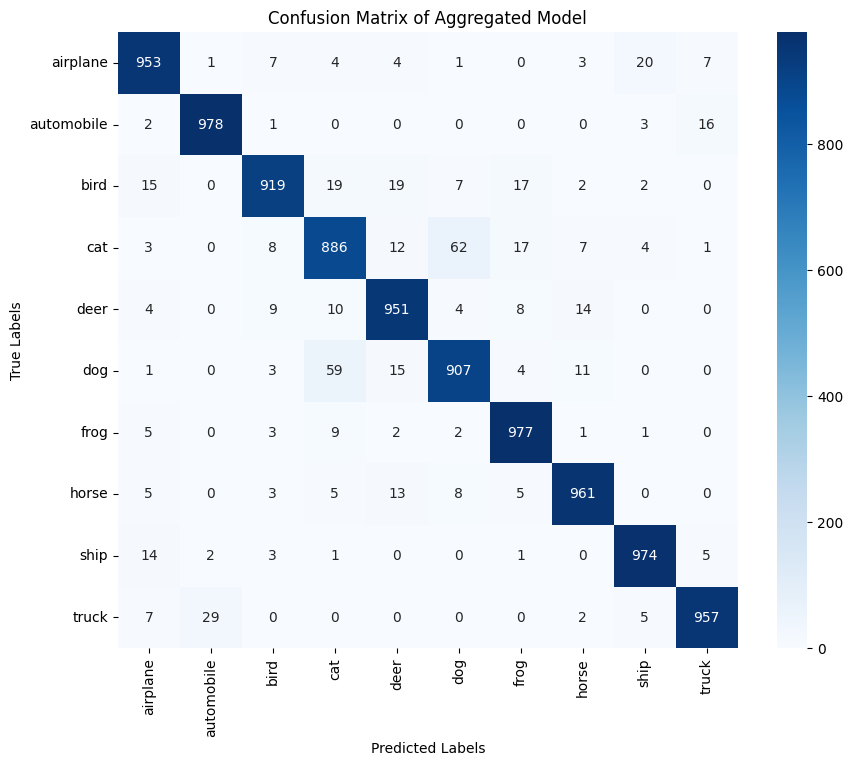

In [26]:
evaluate_aggregated_model(results, classes)

# SISA re-train

## Paths to data info

In [29]:
samples_to_delete = project_root/'experiments/cifar10/naive/cifar10_samples_to_unlearn_20per.json'
sisa_structure = 'sisa_structure.json'
updated_sisa_structure = 'updated_sisa_strucute.json'
deleted_samples = 'deleted_samples.json'

## Update sisa structure -> delete samples 

In [30]:
affected_shards = update_sisa_structure(samples_to_delete, sisa_structure, updated_sisa_structure, deleted_samples)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file

In [31]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

## Models output path

In [32]:
save_path = "./sisa_updated_models"

## Retrain the affected shards

In [33]:
import time

start_time = time.perf_counter()

retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_resnet50, 
    learning_rate=LEARNING_RATE,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Retraining shard: shard_0
Init model...
Done initializing model.
Model ID: 137301525532816, Optimizer ID: 137298103339328, Criterion ID: 137298103342688
  Retraining slice: slice_0


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [1/5], Train Loss: 2.2724, Train Accuracy: 0.1678, Val Loss: 2.2312, Val Accuracy: 0.2959
Epoch 1: New best validation accuracy: 0.2959. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch [2/5], Train Loss: 2.0337, Train Accuracy: 0.5368, Val Loss: 2.0896, Val Accuracy: 0.5019
Epoch 2: New best validation accuracy: 0.5019. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch [3/5], Train Loss: 1.7673, Train Accuracy: 0.7079, Val Loss: 1.8131, Val Accuracy: 0.6030
Epoch 3: New best validation accuracy: 0.6030. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch [4/5], Train Loss: 1.4552, Train Accuracy: 0.7973, Val Loss: 1.4813, Val Accuracy: 0.6367
Epoch 4: New best validation accuracy: 0.6367. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Epoch [5/5], Train Loss: 1.1227, Train Accuracy: 0.8380, Val Loss: 1.1479, Val Accuracy: 0.6667
Epoch 5: New best validation accuracy: 0.6667. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [1/5], Train Loss: 1.0853, Train Accuracy: 0.7197, Val Loss: 0.8121, Val Accuracy: 0.7444
Epoch 1: New best validation accuracy: 0.7444. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch [2/5], Train Loss: 0.7206, Train Accuracy: 0.8379, Val Loss: 0.6277, Val Accuracy: 0.8045
Epoch 2: New best validation accuracy: 0.8045. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch [3/5], Train Loss: 0.4338, Train Accuracy: 0.9127, Val Loss: 0.4976, Val Accuracy: 0.8459
Epoch 3: New best validation accuracy: 0.8459. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch [4/5], Train Loss: 0.2415, Train Accuracy: 0.9574, Val Loss: 0.4655, Val Accuracy: 0.8308


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [5/5], Train Loss: 0.1255, Train Accuracy: 0.9820, Val Loss: 0.4409, Val Accuracy: 0.8647
Epoch 5: New best validation accuracy: 0.8647. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [1/5], Train Loss: 0.4744, Train Accuracy: 0.8466, Val Loss: 0.3806, Val Accuracy: 0.8876
Epoch 1: New best validation accuracy: 0.8876. Model saved to ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Epoch [2/5], Train Loss: 0.2126, Train Accuracy: 0.9440, Val Loss: 0.3676, Val Accuracy: 0.8801


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [3/5], Train Loss: 0.1038, Train Accuracy: 0.9826, Val Loss: 0.3501, Val Accuracy: 0.8951
Epoch 3: New best validation accuracy: 0.8951. Model saved to ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch [4/5], Train Loss: 0.0561, Train Accuracy: 0.9934, Val Loss: 0.3620, Val Accuracy: 0.8914


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch [5/5], Train Loss: 0.0362, Train Accuracy: 0.9963, Val Loss: 0.3683, Val Accuracy: 0.8951
Training complete for ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [1/5], Train Loss: 0.3909, Train Accuracy: 0.8802, Val Loss: 0.3475, Val Accuracy: 0.8741
Epoch 1: New best validation accuracy: 0.8741. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Epoch [2/5], Train Loss: 0.1503, Train Accuracy: 0.9614, Val Loss: 0.3282, Val Accuracy: 0.8963
Epoch 2: New best validation accuracy: 0.8963. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [3/5], Train Loss: 0.0781, Train Accuracy: 0.9844, Val Loss: 0.3503, Val Accuracy: 0.8815


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [4/5], Train Loss: 0.0453, Train Accuracy: 0.9947, Val Loss: 0.3563, Val Accuracy: 0.8815


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [5/5], Train Loss: 0.0300, Train Accuracy: 0.9963, Val Loss: 0.3497, Val Accuracy: 0.9000
Epoch 5: New best validation accuracy: 0.9000. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [1/5], Train Loss: 0.3224, Train Accuracy: 0.9001, Val Loss: 0.1938, Val Accuracy: 0.9440
Epoch 1: New best validation accuracy: 0.9440. Model saved to ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Epoch [2/5], Train Loss: 0.1158, Train Accuracy: 0.9697, Val Loss: 0.1925, Val Accuracy: 0.9403


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch [3/5], Train Loss: 0.0532, Train Accuracy: 0.9921, Val Loss: 0.1894, Val Accuracy: 0.9440


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch [4/5], Train Loss: 0.0296, Train Accuracy: 0.9971, Val Loss: 0.1818, Val Accuracy: 0.9440


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Epoch [5/5], Train Loss: 0.0179, Train Accuracy: 0.9975, Val Loss: 0.1732, Val Accuracy: 0.9403
Training complete for ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_0 to ./sisa_updated_models/shard_0_final_model.pth
Retraining shard: shard_1
Init model...
Done initializing model.
Model ID: 137298101656288, Optimizer ID: 137298102565136, Criterion ID: 137298102566528
  Retraining slice: slice_0


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [1/5], Train Loss: 2.2313, Train Accuracy: 0.2205, Val Loss: 2.2170, Val Accuracy: 0.2974
Epoch 1: New best validation accuracy: 0.2974. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Epoch [2/5], Train Loss: 1.9912, Train Accuracy: 0.5688, Val Loss: 2.0699, Val Accuracy: 0.4498
Epoch 2: New best validation accuracy: 0.4498. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [3/5], Train Loss: 1.7060, Train Accuracy: 0.7366, Val Loss: 1.7426, Val Accuracy: 0.5353
Epoch 3: New best validation accuracy: 0.5353. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [4/5], Train Loss: 1.3846, Train Accuracy: 0.7984, Val Loss: 1.4072, Val Accuracy: 0.6431
Epoch 4: New best validation accuracy: 0.6431. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [5/5], Train Loss: 1.0500, Train Accuracy: 0.8512, Val Loss: 1.0557, Val Accuracy: 0.7212
Epoch 5: New best validation accuracy: 0.7212. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [1/5], Train Loss: 1.0246, Train Accuracy: 0.7440, Val Loss: 0.7989, Val Accuracy: 0.7311
Epoch 1: New best validation accuracy: 0.7311. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [2/5], Train Loss: 0.6483, Train Accuracy: 0.8638, Val Loss: 0.6026, Val Accuracy: 0.7917
Epoch 2: New best validation accuracy: 0.7917. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [3/5], Train Loss: 0.3745, Train Accuracy: 0.9239, Val Loss: 0.5338, Val Accuracy: 0.8295
Epoch 3: New best validation accuracy: 0.8295. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [4/5], Train Loss: 0.2061, Train Accuracy: 0.9651, Val Loss: 0.5126, Val Accuracy: 0.8371
Epoch 4: New best validation accuracy: 0.8371. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [5/5], Train Loss: 0.1113, Train Accuracy: 0.9857, Val Loss: 0.5049, Val Accuracy: 0.8258
Training complete for ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [1/5], Train Loss: 0.4575, Train Accuracy: 0.8552, Val Loss: 0.3505, Val Accuracy: 0.8750
Epoch 1: New best validation accuracy: 0.8750. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch [2/5], Train Loss: 0.2132, Train Accuracy: 0.9442, Val Loss: 0.3344, Val Accuracy: 0.9053
Epoch 2: New best validation accuracy: 0.9053. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [3/5], Train Loss: 0.1064, Train Accuracy: 0.9786, Val Loss: 0.3070, Val Accuracy: 0.9167
Epoch 3: New best validation accuracy: 0.9167. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [4/5], Train Loss: 0.0588, Train Accuracy: 0.9916, Val Loss: 0.3328, Val Accuracy: 0.9015


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Epoch [5/5], Train Loss: 0.0379, Train Accuracy: 0.9958, Val Loss: 0.3303, Val Accuracy: 0.8977
Training complete for ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [1/5], Train Loss: 0.3581, Train Accuracy: 0.8921, Val Loss: 0.3176, Val Accuracy: 0.9026
Epoch 1: New best validation accuracy: 0.9026. Model saved to ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Epoch [2/5], Train Loss: 0.1315, Train Accuracy: 0.9651, Val Loss: 0.2714, Val Accuracy: 0.9176
Epoch 2: New best validation accuracy: 0.9176. Model saved to ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch [3/5], Train Loss: 0.0620, Train Accuracy: 0.9929, Val Loss: 0.2339, Val Accuracy: 0.9288
Epoch 3: New best validation accuracy: 0.9288. Model saved to ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch [4/5], Train Loss: 0.0378, Train Accuracy: 0.9938, Val Loss: 0.2479, Val Accuracy: 0.9139


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [5/5], Train Loss: 0.0262, Train Accuracy: 0.9971, Val Loss: 0.2479, Val Accuracy: 0.9288
Training complete for ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [1/5], Train Loss: 0.3385, Train Accuracy: 0.8948, Val Loss: 0.2954, Val Accuracy: 0.8943
Epoch 1: New best validation accuracy: 0.8943. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [2/5], Train Loss: 0.1216, Train Accuracy: 0.9669, Val Loss: 0.2304, Val Accuracy: 0.9245
Epoch 2: New best validation accuracy: 0.9245. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [3/5], Train Loss: 0.0541, Train Accuracy: 0.9912, Val Loss: 0.2343, Val Accuracy: 0.9321
Epoch 3: New best validation accuracy: 0.9321. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [4/5], Train Loss: 0.0306, Train Accuracy: 0.9966, Val Loss: 0.2342, Val Accuracy: 0.9396
Epoch 4: New best validation accuracy: 0.9396. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch [5/5], Train Loss: 0.0219, Train Accuracy: 0.9979, Val Loss: 0.2132, Val Accuracy: 0.9434
Epoch 5: New best validation accuracy: 0.9434. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_1 to ./sisa_updated_models/shard_1_final_model.pth
Retraining shard: shard_2
Init model...
Done initializing model.
Model ID: 137298102811856, Optimizer ID: 137301525534064, Criterion ID: 137298103400624
  Retraining slice: slice_0


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [1/5], Train Loss: 2.2762, Train Accuracy: 0.1604, Val Loss: 2.2412, Val Accuracy: 0.2205
Epoch 1: New best validation accuracy: 0.2205. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Epoch [2/5], Train Loss: 2.0492, Train Accuracy: 0.5924, Val Loss: 2.1132, Val Accuracy: 0.4373
Epoch 2: New best validation accuracy: 0.4373. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [3/5], Train Loss: 1.7950, Train Accuracy: 0.7743, Val Loss: 1.8573, Val Accuracy: 0.6160
Epoch 3: New best validation accuracy: 0.6160. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [4/5], Train Loss: 1.4839, Train Accuracy: 0.8417, Val Loss: 1.4704, Val Accuracy: 0.6806
Epoch 4: New best validation accuracy: 0.6806. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [5/5], Train Loss: 1.1535, Train Accuracy: 0.8657, Val Loss: 1.0988, Val Accuracy: 0.7605
Epoch 5: New best validation accuracy: 0.7605. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [1/5], Train Loss: 1.0912, Train Accuracy: 0.7412, Val Loss: 0.8120, Val Accuracy: 0.7681
Epoch 1: New best validation accuracy: 0.7681. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [2/5], Train Loss: 0.7058, Train Accuracy: 0.8384, Val Loss: 0.6126, Val Accuracy: 0.8023
Epoch 2: New best validation accuracy: 0.8023. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [3/5], Train Loss: 0.4205, Train Accuracy: 0.9141, Val Loss: 0.5307, Val Accuracy: 0.8289
Epoch 3: New best validation accuracy: 0.8289. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [4/5], Train Loss: 0.2480, Train Accuracy: 0.9512, Val Loss: 0.5008, Val Accuracy: 0.8403
Epoch 4: New best validation accuracy: 0.8403. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [5/5], Train Loss: 0.1417, Train Accuracy: 0.9756, Val Loss: 0.4686, Val Accuracy: 0.8327
Training complete for ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [1/5], Train Loss: 0.4738, Train Accuracy: 0.8436, Val Loss: 0.4800, Val Accuracy: 0.8377
Epoch 1: New best validation accuracy: 0.8377. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [2/5], Train Loss: 0.2259, Train Accuracy: 0.9385, Val Loss: 0.3851, Val Accuracy: 0.8830
Epoch 2: New best validation accuracy: 0.8830. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [3/5], Train Loss: 0.1139, Train Accuracy: 0.9795, Val Loss: 0.3562, Val Accuracy: 0.8943
Epoch 3: New best validation accuracy: 0.8943. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch [4/5], Train Loss: 0.0636, Train Accuracy: 0.9916, Val Loss: 0.3559, Val Accuracy: 0.8981
Epoch 4: New best validation accuracy: 0.8981. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [5/5], Train Loss: 0.0401, Train Accuracy: 0.9941, Val Loss: 0.3533, Val Accuracy: 0.8981
Training complete for ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [1/5], Train Loss: 0.3570, Train Accuracy: 0.8814, Val Loss: 0.4135, Val Accuracy: 0.8657
Epoch 1: New best validation accuracy: 0.8657. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch [2/5], Train Loss: 0.1571, Train Accuracy: 0.9578, Val Loss: 0.3544, Val Accuracy: 0.8657


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch [3/5], Train Loss: 0.0718, Train Accuracy: 0.9859, Val Loss: 0.3389, Val Accuracy: 0.8955
Epoch 3: New best validation accuracy: 0.8955. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [4/5], Train Loss: 0.0410, Train Accuracy: 0.9930, Val Loss: 0.3196, Val Accuracy: 0.8955


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [5/5], Train Loss: 0.0268, Train Accuracy: 0.9979, Val Loss: 0.3343, Val Accuracy: 0.8881
Training complete for ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [1/5], Train Loss: 0.3428, Train Accuracy: 0.8959, Val Loss: 0.2932, Val Accuracy: 0.9173
Epoch 1: New best validation accuracy: 0.9173. Model saved to ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Epoch [2/5], Train Loss: 0.1116, Train Accuracy: 0.9713, Val Loss: 0.2892, Val Accuracy: 0.9248
Epoch 2: New best validation accuracy: 0.9248. Model saved to ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [3/5], Train Loss: 0.0531, Train Accuracy: 0.9904, Val Loss: 0.2787, Val Accuracy: 0.9286
Epoch 3: New best validation accuracy: 0.9286. Model saved to ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [4/5], Train Loss: 0.0278, Train Accuracy: 0.9983, Val Loss: 0.2720, Val Accuracy: 0.9135


Training Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [5/5], Train Loss: 0.0166, Train Accuracy: 0.9988, Val Loss: 0.2576, Val Accuracy: 0.9248
Training complete for ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_2 to ./sisa_updated_models/shard_2_final_model.pth
Execution time: 1551.461374 seconds


## Re-test new SISA models

In [34]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_path, 
    init_model_func=init_model_resnet50,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 137298101105808, Optimizer ID: 137298101755456, Criterion ID: 137298101758576
Loading and testing model: ./sisa_updated_models/shard_0_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_0_final_model.pth:   0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating model: ./sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


Predictions and labels saved to ./sisa_updated_models/shard_0_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 137298103403280, Optimizer ID: 137298101762128, Criterion ID: 137298101757856
Loading and testing model: ./sisa_updated_models/shard_1_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


Predictions and labels saved to ./sisa_updated_models/shard_1_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 137298103407888, Optimizer ID: 137298103396592, Criterion ID: 137298103394000
Loading and testing model: ./sisa_updated_models/shard_2_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]

Predictions and labels saved to ./sisa_updated_models/shard_2_ResNet50_CIFAR10_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [35]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9201
  Precision: 0.9211
  Recall: 0.9201
  F1 Score: 0.9200
Shard shard_1 Metrics:
  Accuracy: 0.9152
  Precision: 0.9153
  Recall: 0.9152
  F1 Score: 0.9150
Shard shard_2 Metrics:
  Accuracy: 0.9172
  Precision: 0.9172
  Recall: 0.9172
  F1 Score: 0.9170

Aggregated Model Metrics:
  Accuracy: 0.9312
  Precision: 0.9314
  Recall: 0.9312
  F1 Score: 0.9311


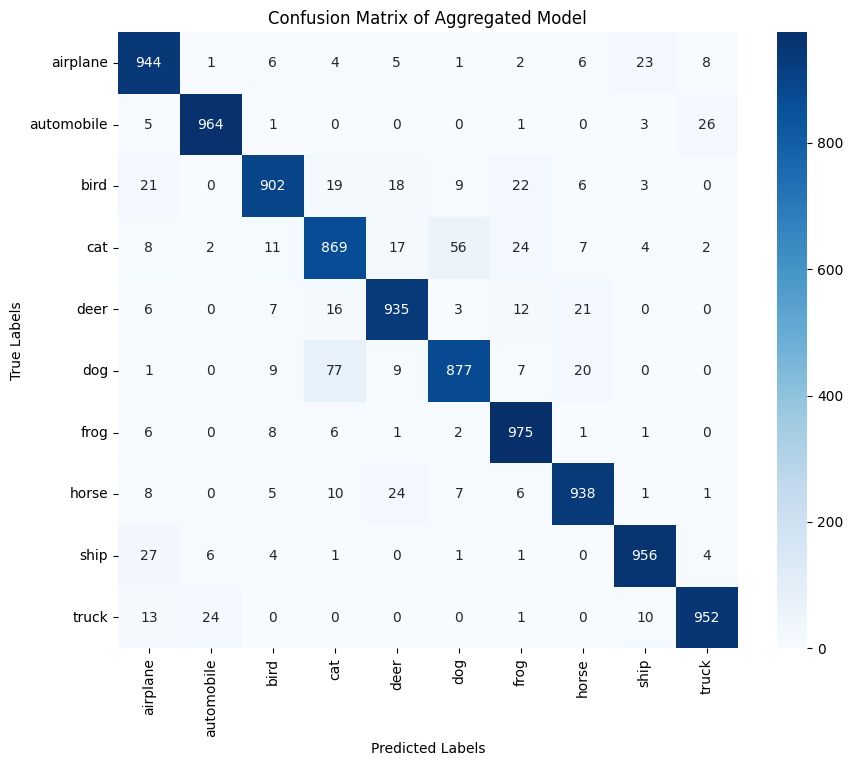

In [36]:
evaluate_aggregated_model(results, classes)